In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MigPreFuncoes
import SlantStack

Imported MigPreFuncoes now
Imported SlantStack now


*******

Frequência da Wavelet: $f_{r} = 40$ Hz

Velocidade constante do modelo: $c = 250$ m/s

$v = \lambda \cdot f$

Para nossa barra estar abaixo do limite de resolução definido entre $\lambda/2$ e $\lambda/4$, temos que definir a largura da barra como 

$ \lambda = \dfrac{v}{f} = \dfrac{250}{40} = 6.25 $ m

$ \lambda/2 \approx 3 \iff  \lambda/4 \approx 1.5 $

********

In [2]:
dx=1 #Discretização em X
dz=0.25 #Discretização em Y
dt=0.25 
nt=nz=120 #Tamanho do Grid em 
ntr=nx=240
c=250

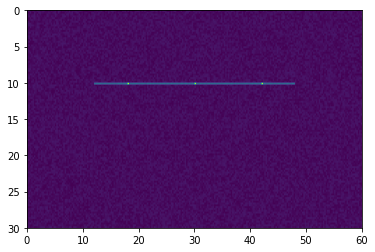

In [3]:
MOD = np.zeros([ntr,nt])

#Barra
x_ini_1 = int(np.round(1*ntr/5))
x_fim_1 = int(np.round(4*ntr/5))

#Pontos Difratores
for i in range(x_ini_1,x_fim_1):
    z = int(np.round(nt/3))
    MOD[i,z]=1
    MOD[int(np.round(1.5*nx/5)),int(np.round(nt/3))]=3
    MOD[int(np.round(2.5*nx/5)),int(np.round(nt/3))]=3
    MOD[int(np.round(3.5*nx/5)),int(np.round(nt/3))]=3

#Adicionando ruído no modelo
nn = np.random.rand(ntr,nt)
MOD = MOD+(nn-0.5)*0.2

R = MOD.T

plt.imshow(MOD.T, aspect="auto", extent=[0,dx*ntr,nz*dz,0])
plt.show()

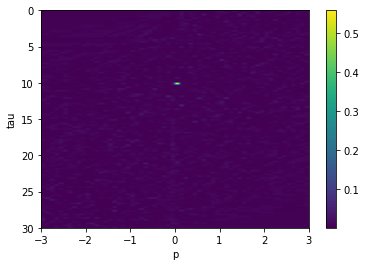

In [4]:
pmin=-3
pmax=3
dp=0.1

S,pmaxS,taumaxS,smax,ip,itau = SlantStack.slant_stack(pmin,pmax,dp,0,nt*dt,dt,MOD.T,1.0,dt,0,0)

plt.imshow(S,extent=[pmin,pmax,nt*dt,0],aspect="auto")
plt.colorbar()
plt.xlabel('p')
plt.ylabel('tau')
plt.show()

In [5]:
t1 = np.degrees(np.arctan(pmaxS))
print("pmax MOD1 =", pmaxS)
print(f"theta 1 = {t1} graus")

pmax MOD1 = 2.6645352591003757e-15
theta 1 = 1.526666247102488e-13 graus


(120, 240)


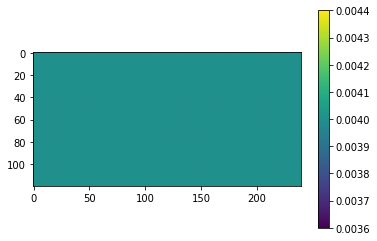

In [4]:
#Modelo de Vagarosidade SW
#c = 250

SW=np.ones([nt,ntr])*1/c
print(SW.shape)

plt.imshow(SW)
plt.colorbar()
plt.show()

In [5]:
#Tabela de tempo de trânsito do modelo de vagarosidade SW

#TT=MigPreFuncoes.raymodel3(SW,dx,ntr,"Data/time_table_barra.npy")

TTh.shape=(240, 120, 240)


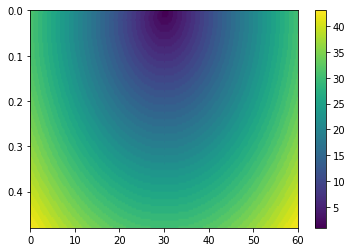

TSX.shape=(120, 240)


In [6]:
with open('Data/time_table_barra.npy', 'rb') as f:
    TTh = np.load(f)

print(f"TTh.shape={TTh.shape}")

dt=0.004

TSX = (TTh[120,:,:]/dt+1).astype(int)  # Traveltime  (indexes)
plt.imshow(TSX,extent=[0, ntr*dx, nt*dt, 0], aspect='auto')
plt.colorbar()
plt.show()

timer=np.round(TTh/dt)+1

print(f"TSX.shape={TSX.shape}")

In [7]:
#Wavelet

nx=ntr
fr=40
nps=136 #era 200, mudei pra 136 e funcionou, tenho que conferir se posso fazer isso mesmo...
dt=.004
rick=MigPreFuncoes.ricker(nps,fr,dt)

sx=10  #index position
sz=0  #index position

tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))

nd2=nt+1; 
W=np.zeros(2*nt);

W[nt:nt+nps-1]=rick[0:nps-1]
x=np.arange(0,nx)
z=np.arange(0,nz)

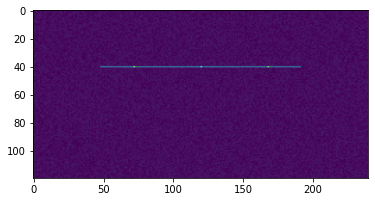

In [8]:
nx=ntr

#Modelo:
R = MOD.T

plt.imshow(R)
plt.show()

In [14]:
#### Create file with all shot gathers
#
#nsx=nx #105  #numero de tiros (pode ser no máximo o valor de TTh axis=0)
#ngx=nx #105   #numero de receptores (pode ser no máximo o valor de TTh axis=1)
##Loop over shots
#
#for isx in range(0,nsx,1):
#    print('shot', isx)
#    D = np.zeros([nt,ngx])
#    TSX = (TTh[isx,:,:]/dt+1).astype(int)  # Traveltime  (indexes)
#
#
#    # Loop Over Traces
#    for gx in range(0,ngx):
#        TXG=(TTh[gx,:,:]/dt+1).astype(int)  # Traveltime in heterogeneous medium (indexes)
#                         
#      
#        #Loop over time sample in a trace
#        for t in range(0,nt):
#            M=W[t-(TSX+TXG)+nt+1]*R
#            D[t,gx]=np.sum(M.flatten('F'));
#            #D[t,gx]=np.sum(M.flatten());
#        gather1=np.diff(D[:,:],n=2,axis=0);
#        
#    filename = 'Data/CSG_diffbar/barra_gather_shot{}'.format(isx)
#    with open(filename, 'wb') as f:
#        np.save(f, gather1)

shot 0
shot 1
shot 2
shot 3
shot 4
shot 5
shot 6
shot 7
shot 8
shot 9
shot 10
shot 11
shot 12
shot 13
shot 14
shot 15
shot 16
shot 17
shot 18
shot 19
shot 20
shot 21
shot 22
shot 23
shot 24
shot 25
shot 26
shot 27
shot 28
shot 29
shot 30
shot 31
shot 32
shot 33
shot 34
shot 35
shot 36
shot 37
shot 38
shot 39
shot 40
shot 41
shot 42
shot 43
shot 44
shot 45
shot 46
shot 47
shot 48
shot 49
shot 50
shot 51
shot 52
shot 53
shot 54
shot 55
shot 56
shot 57
shot 58
shot 59
shot 60
shot 61
shot 62
shot 63
shot 64
shot 65
shot 66
shot 67
shot 68
shot 69
shot 70
shot 71
shot 72
shot 73
shot 74
shot 75
shot 76
shot 77
shot 78
shot 79
shot 80
shot 81
shot 82
shot 83
shot 84
shot 85
shot 86
shot 87
shot 88
shot 89
shot 90
shot 91
shot 92
shot 93
shot 94
shot 95
shot 96
shot 97
shot 98
shot 99
shot 100
shot 101
shot 102
shot 103
shot 104
shot 105
shot 106
shot 107
shot 108
shot 109
shot 110
shot 111
shot 112
shot 113
shot 114
shot 115
shot 116
shot 117
shot 118
shot 119
shot 120
shot 121
shot 122
sho

In [9]:
files = []

for i in range(0,240,1):
    filename = 'Data/CSG_diffbar/barra_gather_shot{}'.format(i)
    
    with open(filename, 'rb') as file:
        (gather) = np.load(file)
        files.append(gather)

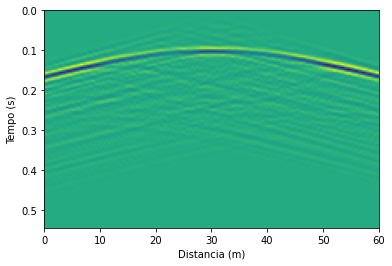

In [10]:
plt.imshow(files[120],aspect='auto',extent=[0, nx*dx, nt*dt, 0])

plt.xlabel('Distancia (m)')
plt.ylabel('Tempo (s)')
plt.show()

In [11]:
shot = 120
filename = 'Data/CSG_diffbar/barra_gather_shot{}'.format(int(shot))

with open(filename, 'rb') as file:
    gather1 = np.load(file)

win=20*dt
dwin=dt
app=15
isx=shot

# Slant Stack

In [26]:
#xwin=twin=25
#m_taumax,m_pmax, s_max = SlantStack.local_window(MOD.T,xwin,twin,dx,dt)

#with open("Data/CSG_diffbar/janela_barra", "wb") as f:
#    np.save(f, m_pmax)

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [57:28<00:00, 28.74s/it]


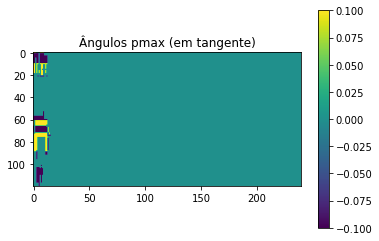

In [12]:
with open("Data/CSG_diffbar/janela_barra", "rb") as f:
    tst = np.load(f)

#plt.figure(figsize=(5,6))
plt.imshow(tst)
plt.title("Ângulos pmax (em tangente)")
plt.colorbar()
plt.show()

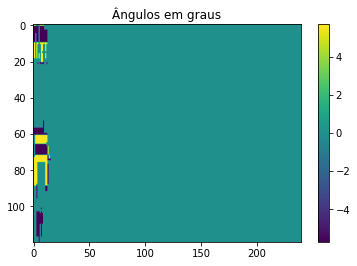

In [13]:
m_theta = np.degrees(np.arctan(tst))
plt.imshow(m_theta, aspect="auto")
plt.title("Ângulos em graus")
plt.colorbar()
plt.show()

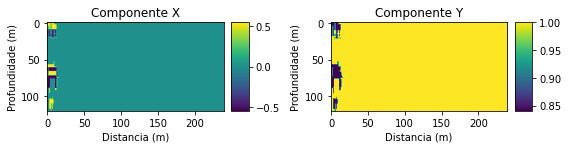

In [14]:
X = np.sin(m_theta)
Y = np.cos(m_theta)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(121)
ax1.set_title("Componente X")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")
im1 = ax1.imshow(X)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
ax2.set_title("Componente Y")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")
im2 = ax2.imshow(Y)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

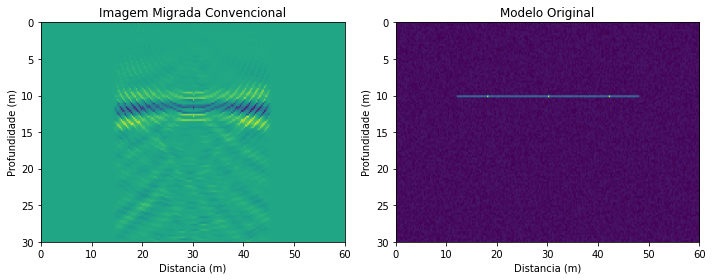

In [30]:
win=10*dt
dwin=dt

app=5

mig_winapp = MigPreFuncoes.migvsp_winapp(gather1,isx,dx,dz,dt,win,dwin,app,TTh,X,Y)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_winapp, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
#falta rodar a partir daqui

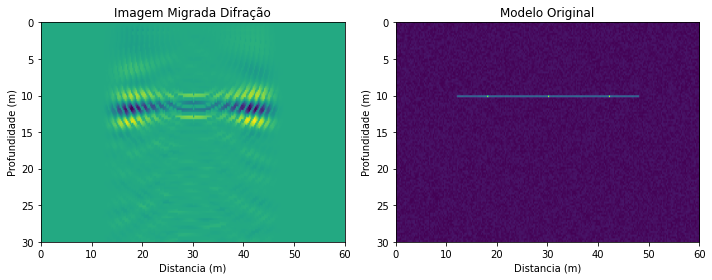

In [15]:
mig_diff = MigPreFuncoes.migvsp_winapp_diff(gather1,isx,dx,dz,dt,win,dwin,app,TTh,X,Y)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Difração")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [24]:
#Stack

80it [01:01,  1.29it/s]


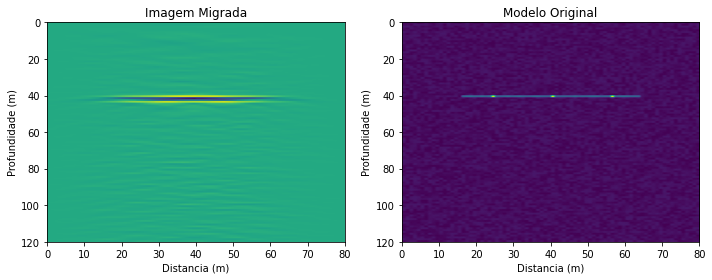

In [25]:
mig_stack = MigPreFuncoes.migstack_winapp(files,isx,dx,dz,dt,win,dwin,app,TTh,X,Y)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_stack, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

shot 0
shot 1
shot 2
shot 3
shot 4
shot 5
shot 6
shot 7
shot 8
shot 9
shot 10
shot 11
shot 12
shot 13
shot 14
shot 15
shot 16
shot 17
shot 18
shot 19
shot 20
shot 21
shot 22
shot 23
shot 24
shot 25
shot 26
shot 27
shot 28
shot 29
shot 30
shot 31
shot 32
shot 33
shot 34
shot 35
shot 36
shot 37
shot 38
shot 39
shot 40
shot 41
shot 42
shot 43
shot 44
shot 45
shot 46
shot 47
shot 48
shot 49
shot 50
shot 51
shot 52
shot 53
shot 54
shot 55
shot 56
shot 57
shot 58
shot 59
shot 60
shot 61
shot 62
shot 63
shot 64
shot 65
shot 66
shot 67
shot 68
shot 69
shot 70
shot 71
shot 72
shot 73
shot 74
shot 75
shot 76
shot 77
shot 78
shot 79


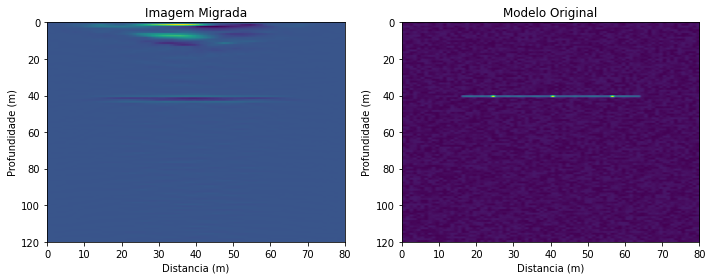

In [26]:
mig_stack_diff = MigPreFuncoes.migstack_winapp_diff(files,isx,dx,dz,dt,win,dwin,app,TTh,X,Y)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_stack_diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()